In [1]:
from lmfit import Parameters
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
from core.util.units import compute_dft

In [2]:
def N14_testing():
    """ Test function to implement the estimator for the N14 fit with offset. """

    # get the model of the three lorentzian peak, this gives you the
    # ability to get the used parameter container for the fit.
    mod, params = fitlogic.make_multiplelorentzian_model(no_of_functions=3)

    x_axis = np.linspace(2720, 2890, 301)*1e6


    sigma = 1e6  # linewidth

    amplitude = -1e4

    minimal_linewidth = (x_axis[1]-x_axis[0])/4
    maximal_linewidth = x_axis[-1]-x_axis[0]
    peak_pos1 = 2852*1e6
    offset = 150000

    params['l0_amplitude'].set(value=amplitude)
    params['l0_center'].set(value=peak_pos1)
    params['l0_sigma'].set(value=sigma)
    params['l1_amplitude'].set(value=amplitude)
    params['l1_center'].set(value=params['l0_center'].value+2.15*1e6)
    params['l1_sigma'].set(value=sigma)
    params['l2_amplitude'].set(value=amplitude)
    params['l2_center'].set(value=params['l1_center'].value+2.15*1e6)
    params['l2_sigma'].set(value=sigma)
    params['offset'].set(value=offset)

    data_noisy = mod.eval(x=x_axis, params=params) + 7000 * np.random.normal(size=x_axis.shape)

    data_smooth_lorentz, offset = fitlogic.find_offset_parameter(x_axis, data_noisy)

    print('offset', offset)

    # level of the data, that means the offset is subtracted and the real data
    # are present
    data_level = data_smooth_lorentz - offset
    minimum_level = data_level.min() * 1.5

    print('minimum level = amplitude:', minimum_level)
    offset_data = np.array([offset]*len(x_axis))

    plt.figure()
    plt.plot(x_axis, data_noisy,'-b', label='data')
    plt.plot(x_axis, data_smooth_lorentz,'-g',linewidth=2.0, label='smoothed data')
    plt.plot(x_axis, offset_data,linewidth=2.0, label='estimated offset')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    plt.figure()
    plt.plot(x_axis, data_level,'-b', label='leveled data')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    # Create now a filter of length 5MHz, then create a step-wise function with
    # three dips. This step-wise function will be convolved with the smoothed
    # data, where the maximal contribution will be if the peaks are within the
    # filter. Take that to obtain from that the accurate peak position:

    # filter of one dip should always have a length of approx linewidth 1MHz
    points_within_1MHz = len(x_axis)/(x_axis.max()-x_axis.min()) * 1e6

    # filter should have a width of 5MHz
    x_filter = np.linspace(0, 5*points_within_1MHz, 5*points_within_1MHz)
    lorentz = np.piecewise(x_filter, [(x_filter >= 0)                   * (x_filter < len(x_filter)*1/5),
                                      (x_filter >= len(x_filter)*1/5)   * (x_filter < len(x_filter)*2/5),
                                      (x_filter >= len(x_filter)*2/5)   * (x_filter < len(x_filter)*3/5),
                                      (x_filter >= len(x_filter)*3/5)   * (x_filter < len(x_filter)*4/5),
                                      (x_filter >= len(x_filter)*4/5)],
                           [1, 0, 1, 0, 1])

    # if the filter is smaller than 5 points a convolution does not make sense
    if len(lorentz) >= 5:
        data_convolved = filters.convolve1d(data_smooth_lorentz,
                                            lorentz/lorentz.sum(),
                                            mode='constant',
                                            cval=data_smooth_lorentz.max())
        x_axis_min = x_axis[data_convolved.argmin()]-2.15*1e6
    else:
        x_axis_min = x_axis[data_smooth_lorentz.argmin()]-2.15*1e6

    plt.figure()
    plt.plot(x_axis, data_convolved,'-b', label='Convoluted result')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    # In order to perform a smooth integral to obtain the area under the curve
    # make an interpolation of the passed data, in case they are very sparse.
    # That increases the accuracy of the calculated Integral.
    # integral of data corresponds to sqrt(2) * Amplitude * Sigma

    smoothing_spline = 1    # must be 1<= smoothing_spline <= 5
    function = InterpolatedUnivariateSpline(x_axis, data_level, k=smoothing_spline)
    integrated_area = function.integral(x_axis[0], x_axis[-1])

    # sigma = abs(integrated_area / (minimum_level/np.pi))
    # That is wrong, so commenting out:
    sigma = abs(integrated_area /(np.pi * minimum_level))/1.5

    amplitude = -1*abs(minimum_level)

    # Since the total amplitude of the lorentzian is depending on sigma it makes
    # sense to vary sigma within an interval, which is smaller than the minimal
    # distance between two points. Then the fit algorithm will have a larger
    # range to determine the amplitude properly. That is the main issue with the
    # fit!
    minimal_linewidth = (x_axis[1]-x_axis[0])/4
    maximal_linewidth = x_axis[-1]-x_axis[0]

    # The linewidth of all the lorentzians are set to be the same! that is a
    # physical constraint for the N14 fitting.

    # Fill the parameter container, with the estimated values, which should be
    # passed to the fit algorithm:
    params['l0_amplitude'].set(value=amplitude, max=-1e-6)
    params['l0_center'].set(value=x_axis_min)
    params['l0_sigma'].set(value=sigma, min=minimal_linewidth,
                                 max=maximal_linewidth)
    params['l1_amplitude'].set(value=amplitude, max=-1e-6)
    params['l1_center'].set(value=x_axis_min+2.15*1e6,
                                  expr='l0_center+2.15*1e6')
    params['l1_sigma'].set(value=sigma, min=minimal_linewidth,
                                 max=maximal_linewidth, expr='l0_sigma')
    params['l2_amplitude'].set(value=amplitude, max=-1e-6)
    params['l2_center'].set(value=x_axis_min+2.15*1e6,
                                  expr='l0_center+4.3*1e6')
    params['l2_sigma'].set(value=sigma, min=minimal_linewidth,
                                 max=maximal_linewidth, expr='l0_sigma')
    params['offset'].set(value=offset)


    result = mod.fit(data_noisy, x=x_axis, params=params)

    result.params['offset'].unit = 'Hz'


    plt.figure()
    plt.plot(x_axis, data_noisy,'-b', label='data')
    plt.plot(x_axis, result.best_fit,'-r', label='best fit result')
    plt.plot(x_axis, result.init_fit,'-g',label='initial fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
    plt.show()
    return result

offset 149919.042937
minimum level = amplitude: -16695.780897


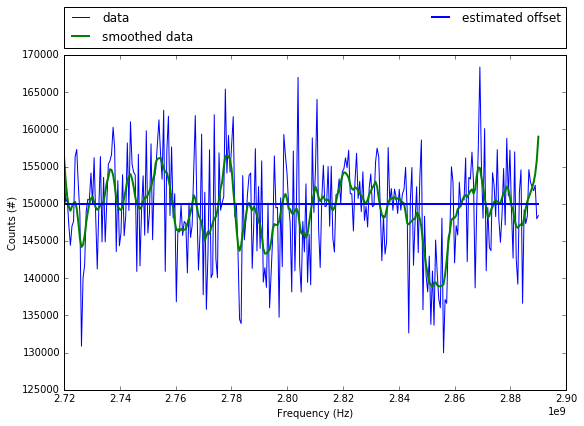

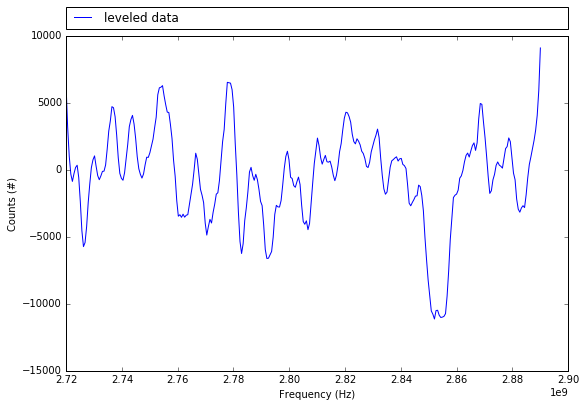

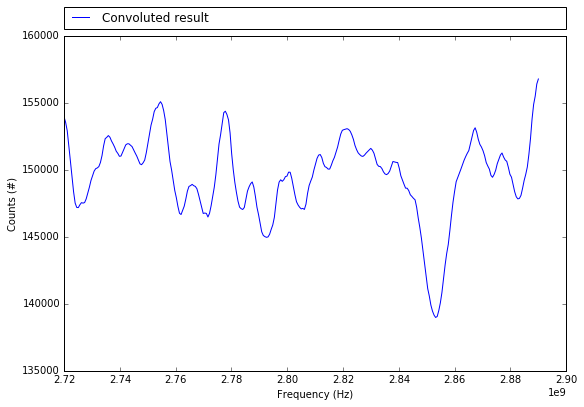

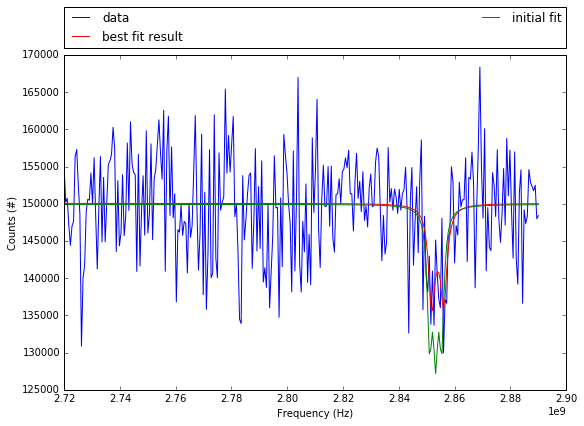

In [3]:
N14_testing()

In [4]:
def N14_testing2():
    """ Test direkt the implemented fit method with simulated data."""

    # get the model of the three lorentzian peak, this gives you the
    # ability to get the used parameter container for the fit.
    mod, params = fitlogic.make_multiplelorentzian_model(no_of_functions=3)

    x_axis = np.linspace(2845, 2860, 101)*1e6

    sigma = 1e6  # linewidth

    amplitude = -3e4

    minimal_linewidth = (x_axis[1]-x_axis[0])/4
    maximal_linewidth = x_axis[-1]-x_axis[0]
    peak_pos1 = 2852*1e6
    offset = 150000

    params['l0_amplitude'].set(value=amplitude)
    params['l0_center'].set(value=peak_pos1)
    params['l0_sigma'].set(value=sigma)
    params['l1_amplitude'].set(value=amplitude)
    params['l1_center'].set(value=params['l0_center'].value+2.15*1e6)
    params['l1_sigma'].set(value=sigma)
    params['l2_amplitude'].set(value=amplitude)
    params['l2_center'].set(value=params['l1_center'].value+2.15*1e6)
    params['l2_sigma'].set(value=sigma)
    params['offset'].set(value=offset)

    data_noisy=(mod.eval(x=x_axis, params=params) + 5000*np.random.normal(size=x_axis.shape))

    result = fitlogic.make_lorentziantriple_fit(x_axis, data_noisy, estimator=fitlogic.estimate_lorentziantriple_N14)

    print(result.fit_report())

    plt.figure()
    plt.plot(x_axis, data_noisy,'-b', label='data')
    plt.plot(x_axis, result.best_fit,'-r', label='best fit result')
    plt.plot(x_axis, result.init_fit,'-g',label='initial fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
    plt.show()


[[Model]]
    ((((Model(amplitude_function, prefix='l0_') * Model(physical_lorentzian, prefix='l0_')) + Model(constant_function)) + (Model(amplitude_function, prefix='l1_') * Model(physical_lorentzian, prefix='l1_'))) + (Model(amplitude_function, prefix='l2_') * Model(physical_lorentzian, prefix='l2_')))
[[Fit Statistics]]
    # function evals   = 52
    # data points      = 101
    # variables        = 6
    chi-square         = 2942089905.198
    reduced chi-square = 30969367.423
[[Variables]]
    l0_fwhm:        2.2513e+06 +/- 2.44e+05 (10.82%)  == '2*l0_sigma'
    l0_contrast:   -19.0725460 +/- 1.726626 (9.05%)  == '(l0_amplitude/offset)*100'
    l1_fwhm:        2.2513e+06 +/- 0        (0.00%)  == '2*l1_sigma'
    l1_contrast:   -15.4857809 +/- 1.993561 (12.87%)  == '(l1_amplitude/offset)*100'
    l2_fwhm:        2.2513e+06 +/- 0        (0.00%)  == '2*l2_sigma'
    l2_contrast:   -19.2565208 +/- 1.726235 (8.96%)  == '(l2_amplitude/offset)*100'
    l0_amplitude:  -28654.2276 +/- 2.6

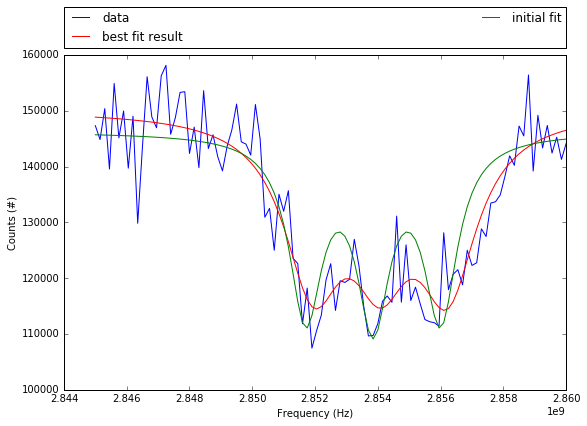

In [5]:
N14_testing2()